# https://github.com/jparkerholder/ASEBO/tree/master/asebo

In [ ]:
# install necessary libraries
!pip install gym-anytrading
!pip install -U jsonpickle

     |████████████████████████████████| 171 kB 5.1 MB/s 


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.linalg import cholesky
from numpy.linalg import LinAlgError
from numpy.random import standard_normal

def aggregate_rollouts(master, A, params, n_samples):
    all_rollouts = np.zeros([n_samples, 2])
    timesteps = 0
    
    for i in range(n_samples):
        w = worker(params, master, A, i)
        all_rollouts[i] = np.reshape(w.do_rollouts(), 2)
        timesteps += w.timesteps

    all_rollouts = (all_rollouts - np.mean(all_rollouts)) / (np.std(all_rollouts)  + 1e-8)
    
    m = np.array(all_rollouts[:, 0] - all_rollouts[:, 1])
    return(m, timesteps)

def ES(params, master, G):
    if params['n_iter'] >= params['k']:
        pca = PCA() 
        pca_fit = pca.fit(G)
        var_exp = pca_fit.explained_variance_ratio_
        var_exp = np.cumsum(var_exp)
        n_samples = np.argmax(var_exp > params['threshold']) + 1
        if n_samples < params['min']:
            n_samples = params['min']
        U = pca_fit.components_[:n_samples]
        UUT = np.matmul(U.T, U)
        U_ort = pca_fit.components_[n_samples:]
        UUT_ort = np.matmul(U_ort.T, U_ort)
        alpha = params['alpha']
        if params['n_iter'] == params['k']:
            n_samples = params['num_sensings']
    else:
        UUT = np.zeros([master.N, master.N])
        alpha = 1
        n_samples = params['num_sensings']
    
    np.random.seed(None)
    cov = (alpha/master.N) * np.eye(master.N) + ((1-alpha) / n_samples) * UUT
    cov *= params['sigma']
    mu = np.repeat(0, master.N)
    A = np.zeros((n_samples, master.N))
    try:
        l = cholesky(cov, check_finite=False, overwrite_a=True)
        for i in range(n_samples):
            try:
                A[i] = np.zeros(master.N) + l.dot(standard_normal(master.N))
            except LinAlgError:
                A[i] = np.random.randn(master.N)
    except LinAlgError:
        for i in range(n_samples):
            A[i] = np.random.randn(master.N)  
    A /= np.linalg.norm(A, axis =-1)[:, np.newaxis]
        
    m, timesteps = aggregate_rollouts(master, A, params, n_samples)
    
    g = np.zeros(master.N)
    for i in range(n_samples):
        eps = A[i, :]
        g += eps * m[i]
    g /= (2 * params['sigma'])
    
    if params['n_iter'] >= params['k']:
        params['alpha'] = np.linalg.norm(np.dot(g, UUT_ort))/np.linalg.norm(np.dot(g, UUT))
    
    return(g, n_samples, timesteps)


In [ ]:
import numpy as np

def Adam(dx, m, v, learning_rate, t, eps = 1e-8, beta1 = 0.9, beta2 = 0.999):
    m = beta1 * m + (1 - beta1) * dx
    mt = m / (1 - beta1 ** t)
    v = beta2 * v + (1-beta2) * (dx **2)
    vt = v / (1 - beta2 ** t)
    update = learning_rate * mt / (np.sqrt(vt) + eps)
    return(update, m, v)

In [ ]:
import numpy as np
from scipy.linalg import toeplitz
import gym
from copy import copy

class ToeplitzPolicy(object):
    
    def __init__(self, policy_params):
         
        self.init_seed = policy_params['seed']
        self.ob_dim = policy_params['ob_dim']
        self.h_dim = policy_params['h_dim']
        self.ac_dim = policy_params['ac_dim']
        
        self.w1 = self.weight_init(self.ob_dim + self.h_dim -1, policy_params['zeros'])
        self.w2 = self.weight_init(self.h_dim * 2 - 1, policy_params['zeros'])
        self.w3 = self.weight_init(self.ac_dim + self.h_dim - 1, policy_params['zeros'])
        
        self.W1 = self.build_layer(self.h_dim, self.ob_dim, self.w1)
        self.W2 = self.build_layer(self.h_dim, self.h_dim, self.w2)
        self.W3 = self.build_layer(self.ac_dim, self.h_dim, self.w3)
        
        self.b1 = self.weight_init(self.h_dim, policy_params['zeros'])
        self.b2 = self.weight_init(self.h_dim, policy_params['zeros'])
    
        self.params = np.concatenate([self.w1, self.b1, self.w2, self.b2, self.w3])
        self.N = len(self.params)

    def weight_init(self, d, zeros=False): #True
        
        if zeros:
            w = np.zeros(d)
        else:
            np.random.seed(self.init_seed)
            w = np.random.rand(d) / np.sqrt(d)
        return(w)
    
    def build_layer(self, d1, d2, v):
        # len v = d1 + d2 - 1
        col = v[:d1]
        row = v[(d1-1):]
        
        W = toeplitz(col, row)
        return(W)
    
    def update(self, vec):
        self.params += vec
        
        self.w1 += vec[:len(self.w1)]
        vec = vec[len(self.w1):]

        self.b1 += vec[:len(self.b1)]
        vec = vec[len(self.b1):]
        
        self.w2 += vec[:len(self.w2)]
        vec = vec[len(self.w2):]

        self.b2 += vec[:len(self.b2)]
        vec = vec[len(self.b2):]

        self.w3 += vec
        
        self.W1 = self.build_layer(self.h_dim, self.ob_dim, self.w1)
        self.W2 = self.build_layer(self.h_dim, self.h_dim, self.w2)
        self.W3 = self.build_layer(self.ac_dim, self.h_dim, self.w3)

    def get_policy_dict_from_policy(self):
        policy_dict = {
          "b1": self.b1,
          "b2": self.b2,
          "W1": self.W1,
          "W2": self.W2,
          "W3": self.W3}
        return policy_dict
        
    def evaluate(self, X):
        X = X.flatten()

        z1 = np.tanh(np.dot(self.W1, X) + self.b1)
        z2 = np.tanh(np.dot(self.W2, z1) + self.b2)

        # z1 = np.dot(self.W1, X) + self.b1
        # z2 = np.dot(self.W2, z1) + self.b2
        # z3 = np.dot(self.W3, z2)

        return (np.tanh(np.dot(self.W3, z2)))* 1.000e+03 # z3 #

class LinearPolicy(object):
    
    def __init__(self, policy_params):
        
        self.init_seed = policy_params['seed']
        self.ob_dim = policy_params['ob_dim']
        self.h_dim = policy_params['h_dim']
        self.ac_dim = policy_params['ac_dim']
        
        self.w = self.weight_init(self.ob_dim * self.ac_dim, policy_params['zeros'])
        self.W = self.w.reshape(self.ac_dim, self.ob_dim)

        self.params = copy(self.w)
        self.N = len(self.params)
    
    def weight_init(self, d, zeros):
        if zeros:
            w = np.zeros(d)
        else:
            np.random.seed(self.init_seed)
            w = np.random.rand(d) / np.sqrt(d)
        return(w)
    
    def update(self, vec):
        self.w += vec
        self.W = self.w.reshape(self.ac_dim, self.ob_dim)
        self.params = copy(self.w)

    def get_policy_dict_from_policy(self):
        policy_dict = {
          "b1": self.b1,
          "b2": self.b2,
          "W1": self.W1,
          "W2": self.W2,
          "W3": self.W3}
        return policy_dict    

    def evaluate(self, X):
        #X = X.reshape(X.size, 1)
        return(np.tanh(np.dot(self.W, X)))

In [ ]:
import numpy as np
import gym
import math

def get_policy(params):
    if params['policy'] == "Toeplitz":
        return(ToeplitzPolicy(params))
    elif params['policy'] == "Linear":
        return(LinearPolicy(params))

class worker(object):
    def __init__(self, params, master, A, i, train=True):
      if params['test'] == False:
        self.env = gym.make('stocks-v0', frame_bound=(params['train_per_start'], params['train_per_start'] + params['train_per_len']), window_size=10)  #frame_bound=(50, 100)

      elif params['test'] == True: 
        params['max_iter'] = params['n_iter'] 
        test_start = params['train_per_start'] + params['train_per_len'] 
        self.env = gym.make('stocks-v0', frame_bound=(test_start, test_start + params['test_per_len']), window_size=10)

      self.env.seed(0)
      self.v = A[i, :] 
      params['zeros'] = True
      self.policy = get_policy(params)
      self.policy.steps = params['steps']
      self.policy.update(master.params)
      self.timesteps = 0
      self.total_profit = 0 
    
    def do_rollouts(self, seed=0, train=True):   
        #print("do_rollouts")
        self.policy.update(self.v)
        up = self.rollout(seed, train)

        self.policy.update(-2 * self.v)
        down = self.rollout(seed, train)
        
        return(np.array([up, down]))

    def do_rollouts_test(self, seed=0, train=True):   
        print("do_rollouts_test")
        self.policy.update(self.v)
        up = self.rollout_test(seed, train)

        self.policy.update(-2 * self.v)
        down = self.rollout_test(seed, train) 

        return(np.array([up, down]))   

    def rollout_test(self, seed=0, train=True):
        params['max_iter'] = params['n_iter'] 
        test_start = params['train_per_start'] + params['train_per_len'] 
        self.env = gym.make('stocks-v0', frame_bound=(test_start, test_start + params['test_per_len']), window_size=10)

        self.env.seed(seed)
        state = self.env.reset()
        position_size = 0
        NAV = cash = Start_Cash = 1000000

        ledger = pd.DataFrame(columns=['trade_size', 'trade_price'])
        self.env._max_episode_steps = params['train_per_len'] # self.policy.steps # this value is always equal to the max steps value set at the beginning of training.
        
        done = False
        while not done:
            if math.isnan(self.policy.evaluate(state)):
              action = 0
              print("self.policy.evaluate(state) = nan")
            elif self.policy.evaluate(state) > 0: 
              if cash < NAV:
                action = math.ceil(self.policy.evaluate(state) * cash / NAV) # reduce the buy signal (number of shares to buy) as cash decreases in proportion to NAV
              else: 
                action = math.ceil(self.policy.evaluate(state)) 
            elif self.policy.evaluate(state) < 0:
              if cash > NAV:
                action = math.floor(self.policy.evaluate(state) * NAV / cash) # reduce the sell signal (number of shares to sell) as cash grows in proportion to NAV
              else:
                action = math.floor(self.policy.evaluate(state))
            if action != 0:
              price = state[state.shape[0]-1, 0] 
              new_trade = pd.Series([action, price], index=['trade_size', 'trade_price'])
              ledger = ledger.append(new_trade, ignore_index=True)
              position_size += action

              cash -= (action * price)
              NAV = cash + position_size * state[state.shape[0]-1, 0]
            Return = (NAV / Start_Cash)-1
            if params['test'] == True:
               #print("Testing TimeSteps:", self.timesteps)
               print("Daily Return: \n", Return)
            if (cash < 0) or (NAV < 0):
              cash = NAV = -1e10
            self.timesteps += 1
            state, reward_not, done, info_not = self.env.step(action)

        return Return
    
    def rollout(self, seed=0, train=True): # train=True
        if params['test'] == False:
          self.env = gym.make('stocks-v0', frame_bound=(params['train_per_start'], params['train_per_start'] + params['train_per_len']), window_size=10)  #frame_bound=(50, 100)

        elif params['test'] == True: 
          params['max_iter'] = params['n_iter'] 
          test_start = params['train_per_start'] + params['train_per_len'] 
          self.env = gym.make('stocks-v0', frame_bound=(test_start, test_start + params['test_per_len']), window_size=10)

        self.env.seed(seed)
        state = self.env.reset()
        position_size = 0
        NAV = cash = Start_Cash = 1000000

        ledger = pd.DataFrame(columns=['trade_size', 'trade_price'])
        self.env._max_episode_steps = self.policy.steps # this value is always equal to the max steps value set at the beginning of training.
        done = False

        while not done:
            if math.isnan(self.policy.evaluate(state)):
              action = 0
              print("self.policy.evaluate(state) = nan")
            elif self.policy.evaluate(state) > 0: 
              if cash < NAV:
                action = math.ceil(self.policy.evaluate(state) * cash / NAV) # reduce the buy signal (number of shares to buy) as cash decreases in proportion to NAV
              else: 
                action = math.ceil(self.policy.evaluate(state)) 
            elif self.policy.evaluate(state) < 0:
              if cash > NAV:
                action = math.floor(self.policy.evaluate(state) * NAV / cash) # reduce the sell signal (number of shares to sell) as cash grows in proportion to NAV
              else:
                action = math.floor(self.policy.evaluate(state))
            if action != 0:
              price = state[state.shape[0]-1, 0] 
              new_trade = pd.Series([action, price], index=['trade_size', 'trade_price'])
              ledger = ledger.append(new_trade, ignore_index=True)
              position_size += action

              cash -= (action * price)
              NAV = cash + position_size * state[state.shape[0]-1, 0]
            Return = (NAV / Start_Cash)-1
            if (cash < 0) or (NAV < 0):
              cash = NAV = -1e10
            self.timesteps += 1
            state, reward_not, done, info_not = self.env.step(action)

        return Return

    def get_policy_dict_from_worker(self):
      policy_dict = self.policy.get_policy_dict_from_policy()
      return policy_dict

In [ ]:
import parser
import argparse
import numpy as np
import pandas as pd
import os

import array
import random
import math
import jsonpickle

import jsonpickle.ext.numpy as jsonpickle_numpy
jsonpickle_numpy.register_handlers()
import jsonpickle.ext.pandas as jsonpickle_pandas
jsonpickle_pandas.register_handlers()

import gym_anytrading
from gym_anytrading.envs import TradingEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import STOCKS_GOOGL

Train_Frame_start = 10

def run_asebo(params):

    train_env = gym.make('stocks-v0', frame_bound=(params['train_per_start'], params['train_per_start'] + params['train_per_len']), window_size=10)  #frame_bound=(50, 100)

    test_start = params['train_per_start'] + params['train_per_len'] 
    test_env = gym.make('stocks-v0', frame_bound=(test_start, test_start + params['test_per_len']), window_size=10)  #frame_bound=(50, 100)
    
    env = train_env  

    params['ob_dim'] = np.prod(np.asarray(env.observation_space.shape))
    params['ac_dim'] = 1

    m = 0
    v = 0

    params['k'] += -1
    params['alpha'] = 1
        
    params['zeros'] = True
    master = get_policy(params)
    
    if params['log']:
        params['num_sensings'] = 4 + int(3 * np.log(master.N))
    if params['k'] > master.N:
        params['k'] = master.N

    n_eps = 0
    n_iter = 1
    ts_cumulative = 0
    ts = []
    rollouts = []
    rewards = []
    samples = []
    alphas = []
    G = []
    
    Test_n_eps = 0
    Test_n_iter = 1
    Test_ts_cumulative = 0
    Test_ts = []
    Test_rollouts = []
    test_rewards = []
    test_samples = []
    Test_alphas = []
    Test_G = []

    train_env = True

    while n_iter < params['max_iter']:
        params['n_iter'] = n_iter
        #print("n_iter: ", n_iter)
        gradient, n_samples, timesteps = ES(params, master, G)
        ts_cumulative += timesteps
        ts.append(ts_cumulative)
        alphas.append(params['alpha'])

        if n_iter == 1:
            G = np.array(gradient)
        else:
            G *= params['decay']
            G = np.vstack([G, gradient])
        n_eps += 2 * n_samples
        rollouts.append(n_eps)
        gradient /= (np.linalg.norm(gradient) / master.N + 1e-8)
        update, m, v = Adam(gradient, m, v, params['learning_rate'], n_iter)
            
        master.update(update)
        train_policy = worker(params, master, np.zeros([1, master.N]), 0) #was test_policy
        reward = train_policy.rollout(train = False) #was test_policy

        rewards.append(reward)
        samples.append(n_samples)    
        print('Iteration: %s, Rollouts: %s, Reward: %s, Alpha: %s, Samples: %s' %(n_iter, n_eps, reward, params['alpha'], n_samples))
        n_iter += 1
        
        out = pd.DataFrame({'Rollouts': rollouts, 'Reward': rewards, 'Samples': samples, 'Timesteps': ts, 'Alpha': alphas})
        # out.to_csv(model_params+'/Seed%s.csv' %(params['seed']), index=False)
        out.to_csv('/content/drive/MyDrive/Colab_Notebooks/ASEBO_ES_for_Algo_Trading/Test_Model_Params/Seed%s.csv' %(params['seed']), index=False)
        
        #if params['test'] == True:
          # print("Test Results: \n")
          # test_rewards.append(reward)
          # test_samples.append(n_samples)    
          # print('Iteration: %s, Reward: %s, Alpha: %s, Samples: %s' %(n_iter, reward, params['alpha'], n_samples))
          # n_iter += 1

          # test_out = pd.DataFrame({'Rollouts': rollouts, 'Reward': rewards, 'Samples': samples, 'Timesteps': ts, 'Test_Alpha': alphas})

          # out.to_csv(model_params+'/Seed%s.csv' %(params['seed']), index=False)
          # test_out.to_csv('/content/drive/MyDrive/Colab_Notebooks/ASEBO_ES_for_Algo_Trading/Train_Model_Params/Seed%s.csv' %(params['seed']), index=False)
        
        if (reward > 0.010) and (n_iter > params['k']) and (params['test'] == False):
          params['test'] = True
          print("Test Environment Results: \n")
          params['n_iter'] = n_iter
          print("n_iter: ", n_iter)
          gradient, n_samples, timesteps = ES(params, master, G)
          ts_cumulative += timesteps
          ts.append(ts_cumulative)
          alphas.append(params['alpha'])

          if n_iter == 1:
              G = np.array(gradient)
          else:
              G *= params['decay']
              G = np.vstack([G, gradient])
          n_eps += 2 * n_samples
          rollouts.append(n_eps)
          gradient /= (np.linalg.norm(gradient) / master.N + 1e-8)
          update, m, v = Adam(gradient, m, v, params['learning_rate'], n_iter)
              
          master.update(update)
          test_policy = worker(params, master, np.zeros([1, master.N]), 0) #was test_policy
          reward = test_policy.rollout_test(train = False) #was test_policy

          rewards.append(reward)
          samples.append(n_samples)    
          print('Iteration: %s, Rollouts: %s, Reward: %s, Alpha: %s, Samples: %s' %(n_iter, n_eps, reward, params['alpha'], n_samples))
          n_iter += 1


        if n_iter == params['max_iter']:
          print("Train results: \n")
          print(out)
          print(("\n"))
          print("Test results: \n")
          print(test_out)
          policy_dict = train_policy.get_policy_dict_from_worker()  #create dictionary of parameter values
          # print(policy_dict)
          policy_params_jp = jsonpickle.encode(policy_dict)     # save policy as a jsonpickle
          text_file = open('/content/drive/MyDrive/Colab_Notebooks/ASEBO_ES_for_Algo_Trading/Train_Model_Params/'+'policy_params_str', "w") #open text file
          text_file.write(policy_params_jp)  #write string to file
          text_file.close() #close file
          #print("train_policy is pickled")

if __name__ == '__main__':

    # [S, HD, Max, K, NS, DC] = (100, 64/128, 50, 8, 50, .99)

    parser = argparse.ArgumentParser()
    parser.add_argument('--env_name', type=str, default='stocks-v0')

    parser.add_argument('--test', type=bool, default=False)

    parser.add_argument('--train_per_start', type=int, default=10)
    parser.add_argument('--train_per_len', type=int, default=50)
    parser.add_argument('--test_per_len', type=int, default=100)
 
    parser.add_argument('--steps', '-s', type=int, default=25) #1000
    parser.add_argument('--h_dim', '-hd', type=int, default=32) #32 #128
    parser.add_argument('--start', '-st', type=int, default=0)
    parser.add_argument('--max_iter', '-it', type=int, default=20) #1000
    parser.add_argument('--seed', '-se', type=int, default=0) #0

    parser.add_argument('--k', '-k', type=int, default=8) #8
    parser.add_argument('--num_sensings', '-sn', type=int, default=50) #100
    parser.add_argument('--log', '-lg', type=int, default=0)
    parser.add_argument('--threshold', '-pc', type=float, default= .995) 
    parser.add_argument('--decay', '-dc', type=float, default=0.99)
    parser.add_argument('--learning_rate', '-lr', type=float, default= .01) 
    parser.add_argument('--filename', '-f', type=str, default='')
    parser.add_argument('--policy', '-po', type=str, default='Toeplitz') # Linear or Toeplitz

    parser.add_argument('--shift', '-sh', type=int, default=0)
    parser.add_argument('--min', '-mi', type=int, default=10)
    parser.add_argument('--sigma', '-si', type=float, default=0.1)

    args = parser.parse_args()
    params = vars(args)


In [ ]:
import IPython

run_asebo(params)

display(IPython.display.Audio(url="http://commondatastorage.googleapis.com/codeskulptor-demos/pyman_assets/ateapill.ogg", autoplay=True))

Iteration: 1, Rollouts: 100, Reward: -0.0015605501860002091, Alpha: 1, Samples: 50
Iteration: 2, Rollouts: 200, Reward: -0.005274578370999539, Alpha: 1, Samples: 50
Iteration: 3, Rollouts: 300, Reward: -0.0053629316999995735, Alpha: 1, Samples: 50
Iteration: 4, Rollouts: 400, Reward: 0.0034148340690001167, Alpha: 1, Samples: 50
Iteration: 5, Rollouts: 500, Reward: 0.014975462034000131, Alpha: 1, Samples: 50
Iteration: 6, Rollouts: 600, Reward: 0.02403006966800003, Alpha: 1, Samples: 50
Iteration: 7, Rollouts: 700, Reward: 0.036078555652000244, Alpha: 0.0, Samples: 50
Test Environment Results: 

n_iter:  8
Daily Return: 
 0.0
Daily Return: 
 1.5616400000029174e-05
Daily Return: 
 -8.994405500006852e-05
Daily Return: 
 0.0018272326029999952
Daily Return: 
 0.0025790499119997534
Daily Return: 
 0.003251542886999914
Daily Return: 
 0.003859350086999891
Daily Return: 
 0.002973845186999835
Daily Return: 
 0.0024009681669998617
Daily Return: 
 0.0019715141419998083
Daily Return: 
 0.00086931

In [ ]:
#[S, HD, Max, K,  NS, TH, LR] = (1000, 32, 16, 16, 100, .995, .01)

'''
these did not work:
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 100, 64, 100, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 100, 64, 100, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 1000, 8, 100, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (100, 32, 50, 16, 64, .995, .1 )
    [S, HD, Max, K,  NS, TH, LR] = (1000, 32, 25, 16, 64, .995, .05)
 these did work:
                                   (1000, 32, 500, 8, 100, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 32, 10, 16, 8, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 1000, 8, 100, .995, .01) # then this one didn't work?
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 25, 64, 100, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 20, 64, 100, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 16, 64, 64, .995, .01)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 16, 32, 100, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 16, 32, 64, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 64, 16, 16, 64, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 32, 16, 16, 64, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 32, 20, 16, 64, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 32, 15, 16, 64, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (1000, 32, 10, 16, 64, .995, .05)
    [S, HD, Max, K,  NS, TH, LR] = (100, 32, 10, 16, 64, .995, .1)
    [S, HD, Max, K,  NS, TH, LR] = (100, 32, 5, 16, 64, .995, .1 )
    [S, HD, Max, K,  NS, TH, LR] = (100, 8, 5, 16, 64, .995, .1 )
    [S, HD, Max, K,  NS, TH, LR] = (10, 8, 5, 16, 64, .995, .1 )
    [S, HD, Max, K,  NS, TH, LR] = (10, 8, 5, 16, 32, .995, .1 )
    [S, HD, Max, K,  NS, TH, LR] = (10, 8, 5, 16, 32, .5, .1 ) 
    [S, HD, Max, K,  NS, TH, LR] = (5, 8, 5, 8, 10, .995, .01)
'''    

# Reconstruct Trained Neural Net Policy

In [ ]:
## Create Policy Class
class NeuralNet(object):

  def __init__(self, policy, h_dim = 16, ob_dim = 10, ac_dim = 1):

        self.b1 = policy['b1'] 
        self.b2 = policy['b2'] 

        self.W1 = policy['W1'] 
        self.W2 = policy['W2'] 
        self.W3 = policy['W3'] 

  def evaluate(self, X):
      X = X.flatten()
      z1 = np.tanh(np.dot(self.W1, X) + self.b1)
      z2 = np.tanh(np.dot(self.W2, z1) + self.b2)
      return (np.tanh(np.dot(self.W3, z2))) * 1.000e+03

## Open Pickled Policy Parameters 
text_file = open('/content/drive/MyDrive/Colab_Notebooks/ASEBO_ES_for_Algo_Trading/Model_Params/'+'policy_params_str', "r") #open text file in read mode
policy_str = text_file.read() #read whole file to a string
text_file.close() #close file

## Instantiate Trained Policy
policy = jsonpickle.decode(policy_str) 
print(policy)
policy = NeuralNet(policy)
policy            

{'b1': array([ 0.16713066,  0.40851343, -0.07037188,  0.16444565, -0.07341106,
        0.00413785,  0.0940952 , -0.28007598,  0.10942843, -0.1008653 ,
        0.50026087,  0.12983554, -0.00383781, -0.10144314,  0.10002931,
        0.03152106, -0.16554465,  0.28353316,  0.3532276 ,  0.30362607,
       -0.21774032,  0.23279591, -0.02687801,  0.38988185,  0.10199074,
        0.08055966,  0.41816402,  0.03860419,  0.58828026,  0.28697038,
       -0.23225691,  0.20007169]), 'b2': array([ 0.09154687, -0.24833158, -0.38840735,  0.137581  ,  0.05771615,
        0.29734732, -0.57641141,  0.00690769,  0.36279483,  0.20519251,
       -0.16922556,  0.40106031, -0.60071775,  0.01898212,  0.15434533,
       -0.41425811,  0.08252743, -0.05553726, -0.19076758, -0.19700521,
       -0.18524731, -0.24709788,  0.04189267, -0.43970412, -0.15914946,
       -0.03906607, -0.10320033, -0.607302  , -0.04578689,  0.14867156,
       -0.03389437,  0.00459951]), 'W1': array([[-0.51205785, -0.11026839, -0.10205193, 

# worker.py

In [ ]:
# This is a test but as a separate piece of code


import matplotlib.pyplot as plt
import pandas as pd

position_size = 0
NAV = cash = 50000

ledger = pd.DataFrame(columns=['trade_size', 'trade_price'])
wallet_history = pd.DataFrame(columns = ['cash', 'NAV', 'position_size']) 

# env = gym.make('stocks-v0', frame_bound=(60, 110), window_size=10) # for testing
env = gym.make('stocks-v0', frame_bound=(10, 60), window_size=10)
env.seed(0)
state = env.reset()

#while not done:
while True:
    print(state)
    print(policy.evaluate(state))
    if math.isnan(policy.evaluate(state)):
      action = 0
      print("policy.evaluate(state) = nan")
    elif policy.evaluate(state) > 0: 
      if cash < NAV:
        action = math.ceil(policy.evaluate(state) * cash / NAV) # reduce the buy signal (number of shares to buy) as cash decreases in proportion to NAV
      else: 
        action = math.ceil(policy.evaluate(state)) 
    elif policy.evaluate(state) < 0:
      if cash > NAV:
        action = math.floor(policy.evaluate(state) * NAV / cash) # reduce the sell signal (number of shares to sell) as cash grows in proportion to NAV
      else:
        action = math.floor(policy.evaluate(state))
    if action != 0:
      price = state[state.shape[0]-1, 0] 
      new_trade = pd.Series([action, price], index=['trade_size', 'trade_price'])
      ledger = ledger.append(new_trade, ignore_index=True)
      position_size += action
      cash -= (action * price)
      NAV = cash + position_size * state[state.shape[0]-1, 0]
      wallet = pd.Series([round(cash, 2), round(NAV, 2), position_size], index=['cash', 'NAV', 'position_size']) 
      wallet_history =  wallet_history.append(wallet, ignore_index=True)
      print("Action:", action)
    state, reward_, done, info = env.step(action)

    if done:
        print("wallet_history: \n", wallet_history)
        #print("ledger: \n", ledger)
        break




[[196.946945   0.      ]
 [202.382385   5.43544 ]
 [202.982986   0.600601]
 [205.405411   2.422425]
 [208.823822   3.418411]
 [213.4935     4.669678]
 [214.414413   0.920913]
 [216.041046   1.626633]
 [220.360367   4.319321]
 [222.382385   2.022018]]


NameError: ignored

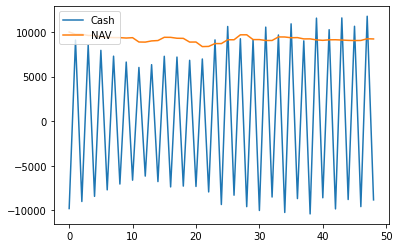

In [ ]:
#ax = wallet_history.plot(x="Iterations", y=["", "B", "C"])
wallet_history.plot(y=["cash", "NAV"], )
plt.legend(['Cash', 'NAV'], loc='upper left')
plt.show()

In [ ]:
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import gym

custom_env = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 10,
               frame_bound = (10, 300),
               unit_side = 'right')

print("env information:")
print("> shape:", env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", env.prices.shape)
print("> signal_features.shape:", env.signal_features.shape)
print("> max_possible_profit:", env.max_possible_profit())
print("env.action_space:", env.action_space)

print()
print("custom_env information:")
print("> shape:", custom_env.shape)
print("> df.shape:", env.df.shape)
print("> prices.shape:", custom_env.prices.shape)
print("> signal_features.shape:", custom_env.signal_features.shape)
print("> max_possible_profit:", custom_env.max_possible_profit())

env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (60,)
> signal_features.shape: (60, 2)
> max_possible_profit: 1.0149155434240176
env.action_space: Discrete(2)

custom_env information:
> shape: (10, 2)
> df.shape: (6225, 5)
> prices.shape: (300,)
> signal_features.shape: (300, 2)
> max_possible_profit: 1.122900180008982
